In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/us_life_expectancy.csv')

In [3]:
data

,cartodb_id,countyfp,statefp,statename,countyname,countyfips,tractname,ratio,statemhir,tractmhir,...,BlackorA,AmericanI,Asianalon,NativeHaw,TwoorMor,Hispanico,Whitealon,county,lon,lat
0,80,57,12,Florida,"Hillsborough County, Florida",12057,"Census Tract 108.14, Hillsborough County, Florida",0.575,47212,27143,...,17.4,0.5,3.9,0.1,2.5,26.0,52.3,County,-82.430705,27.873952
1,398,213,48,Texas,"Henderson County, Texas",48213,"Census Tract 9509.01, Henderson County, Texas",0.752,52576,39558,...,6.6,0.8,0.6,0.1,1.6,11.8,79.4,County,-95.853592,32.211895
2,409,409,48,Texas,"San Patricio County, Texas",48409,"Census Tract 102.01, San Patricio County, Texas",0.708,52576,37231,...,2.1,0.9,1.1,0.1,1.4,55.4,40.8,County,-97.244675,27.859829
3,647,5,24,Maryland,"Baltimore County, Maryland",24005,"Census Tract 4209, Baltimore County, Maryland",0.485,74149,35996,...,27.5,0.4,5.7,0.1,2.3,4.8,60.5,County,-76.640195,39.463417
4,712,31,13,Georgia,"Bulloch County, Georgia",13031,"Census Tract 1104.03, Bulloch County, Georgia",0.367,49342,18103,...,28.9,0.4,1.6,0.1,1.6,3.6,64.6,County,-81.743179,32.396803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,4637,101,54,West Virginia,"Webster County, West Virginia",54101,"Census Tract 9701, Webster County, West Virginia",0.683,41576,28416,...,0.4,0.1,0.3,0.0,1.1,0.4,97.7,County,-80.421865,38.494706
3980,4638,103,55,Wisconsin,"Richland County, Wisconsin",55103,"Census Tract 9702, Richland County, Wisconsin",1.033,52738,54477,...,0.6,0.4,0.6,0.0,0.9,2.2,95.4,County,-90.429483,43.375636
3981,4639,21,8,Colorado,"Conejos County, Colorado",8021,"Census Tract 9748, Conejos County, Colorado",0.538,59448,31957,...,0.6,3.5,0.7,0.2,2.2,53.9,43.6,County,-106.191603,37.200716
3982,4640,47,16,Idaho,"Gooding County, Idaho",16047,"Census Tract 9602, Gooding County, Idaho",0.893,47334,42285,...,0.5,1.8,0.8,0.2,1.8,28.8,68.5,County,-114.811564,42.970922


In [37]:
female_le_q2 = data['le_racea_4']

In [14]:
features = data[['ratio', 'Diversity', 'Asianalon', 'NativeHaw', 'TwoorMor', 'Hispanico', 'Whitealon']]

In [15]:
loc = data[['lon', 'lat']]

In [38]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, female_le_q2, loc, train_size=0.8, random_state=42)

In [39]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [40]:
model = xgb.XGBRegressor(n_estimators=300, max_depth=2, min_child_weight=1, colsample_bytree=0.8)

In [41]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
model.score(X_test, y_test)

0.4772960229035067

In [43]:
model.score(X_train, y_train)

0.5822709395125834

In [13]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 3)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

100%|██████████| 7/7 [00:00<00:00, 41.08it/s]


KeyboardInterrupt: 

In [15]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
ratio,0.867168,0.864752,3.186221,75.062149,61.269543
Diversity,0.884712,0.891507,2.587845,61.726715,53.096344
Asianalon,0.927318,0.985930,2.154060,329.786682,330.758545
NativeHaw,0.894737,0.716142,1.628053,9.337606,8.211256
TwoorMor,0.864662,0.860282,2.876939,59.238960,43.342976
Hispanico,0.907268,0.955095,2.941001,192.619263,173.065552
Whitealon,0.909774,0.787053,4.633781,100.832352,74.831604


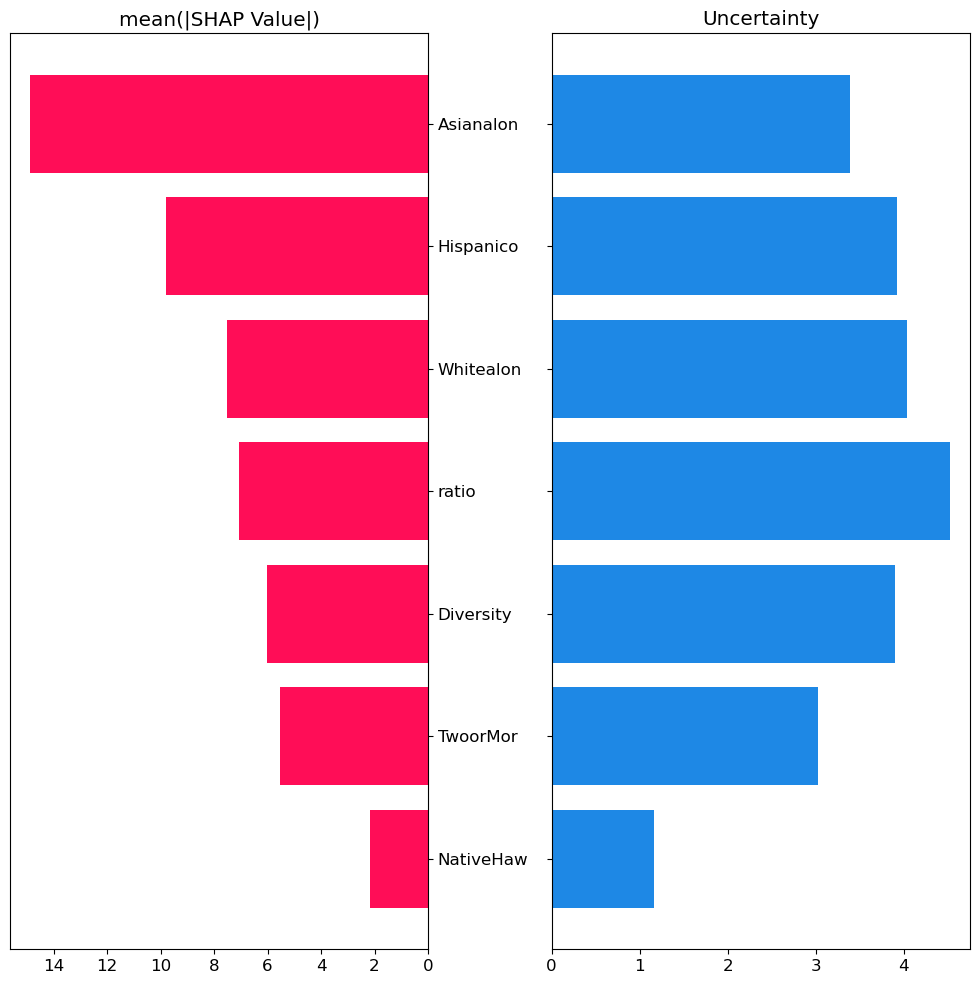

In [16]:
results.plot_absolute_shap_value_with_uncertainty()

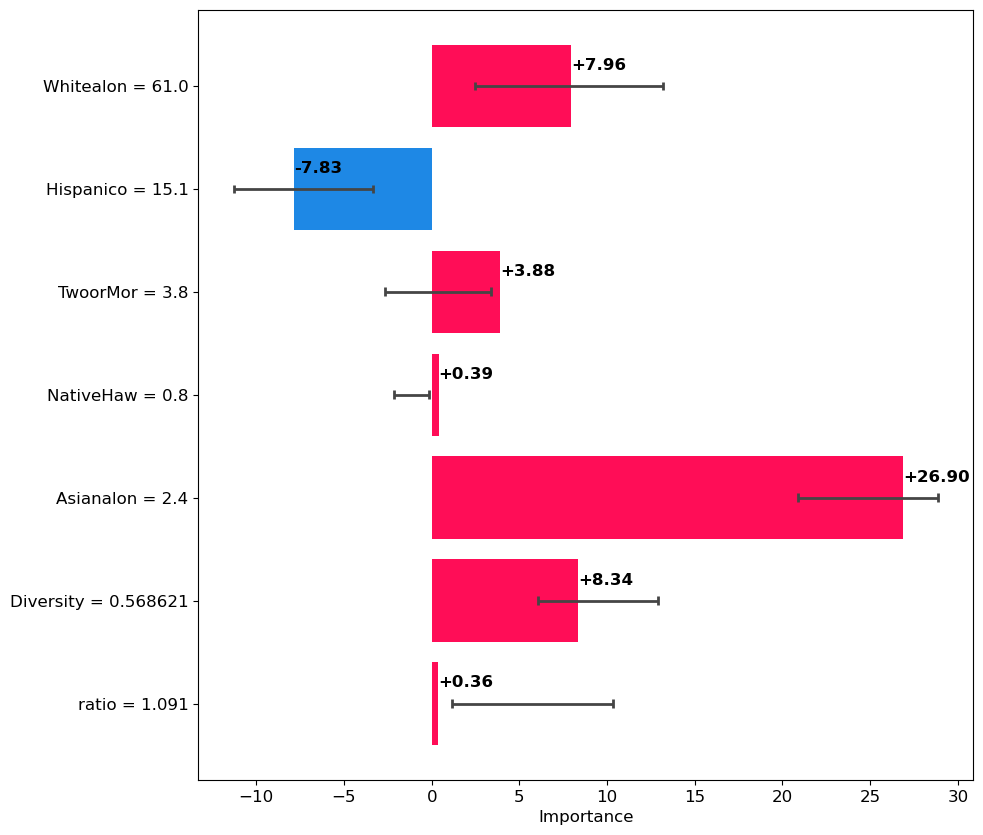

In [17]:
results.plot_shap_values_with_uncertainty(10)

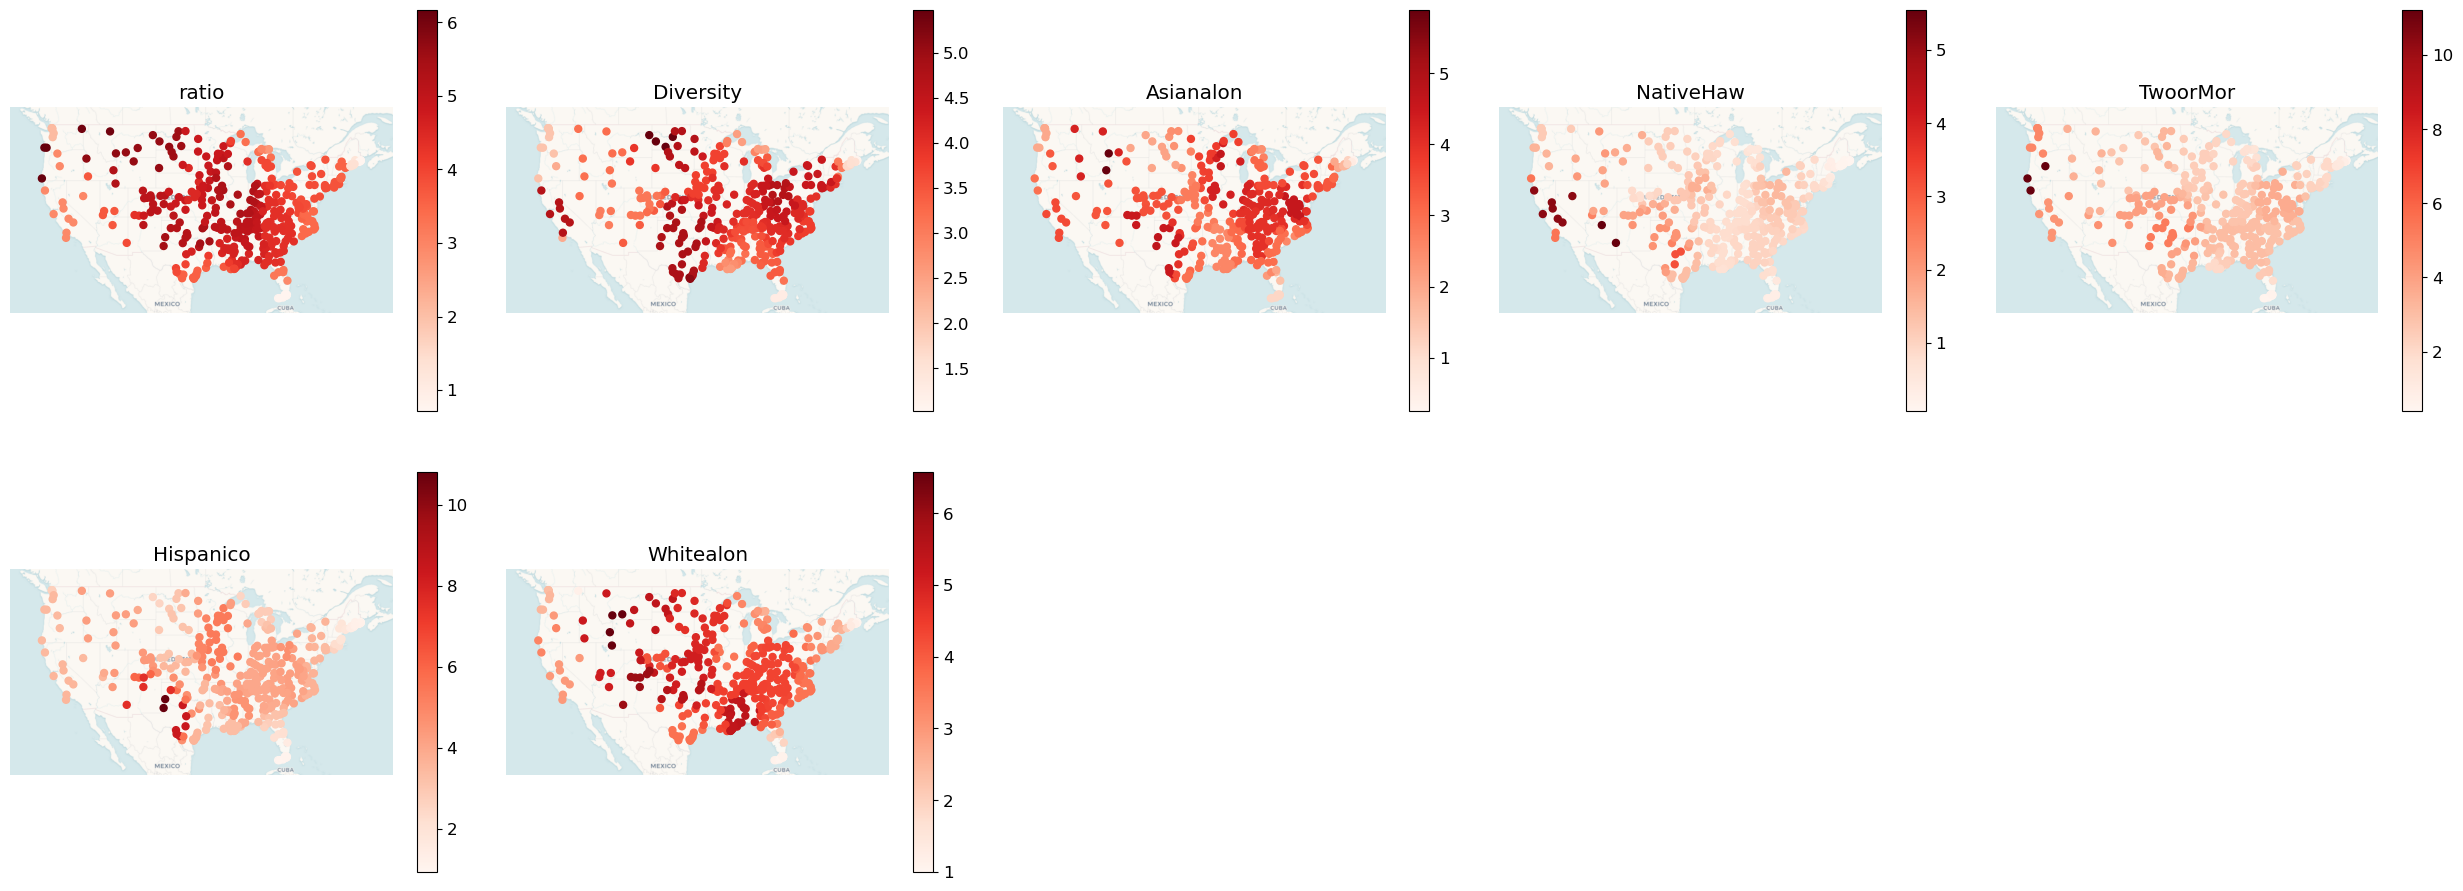

In [18]:
results.plot_geo_uncertainty(figsize=(25, 15), shrink=0.4)

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


ValueError: X data must not contain Inf nor NaN

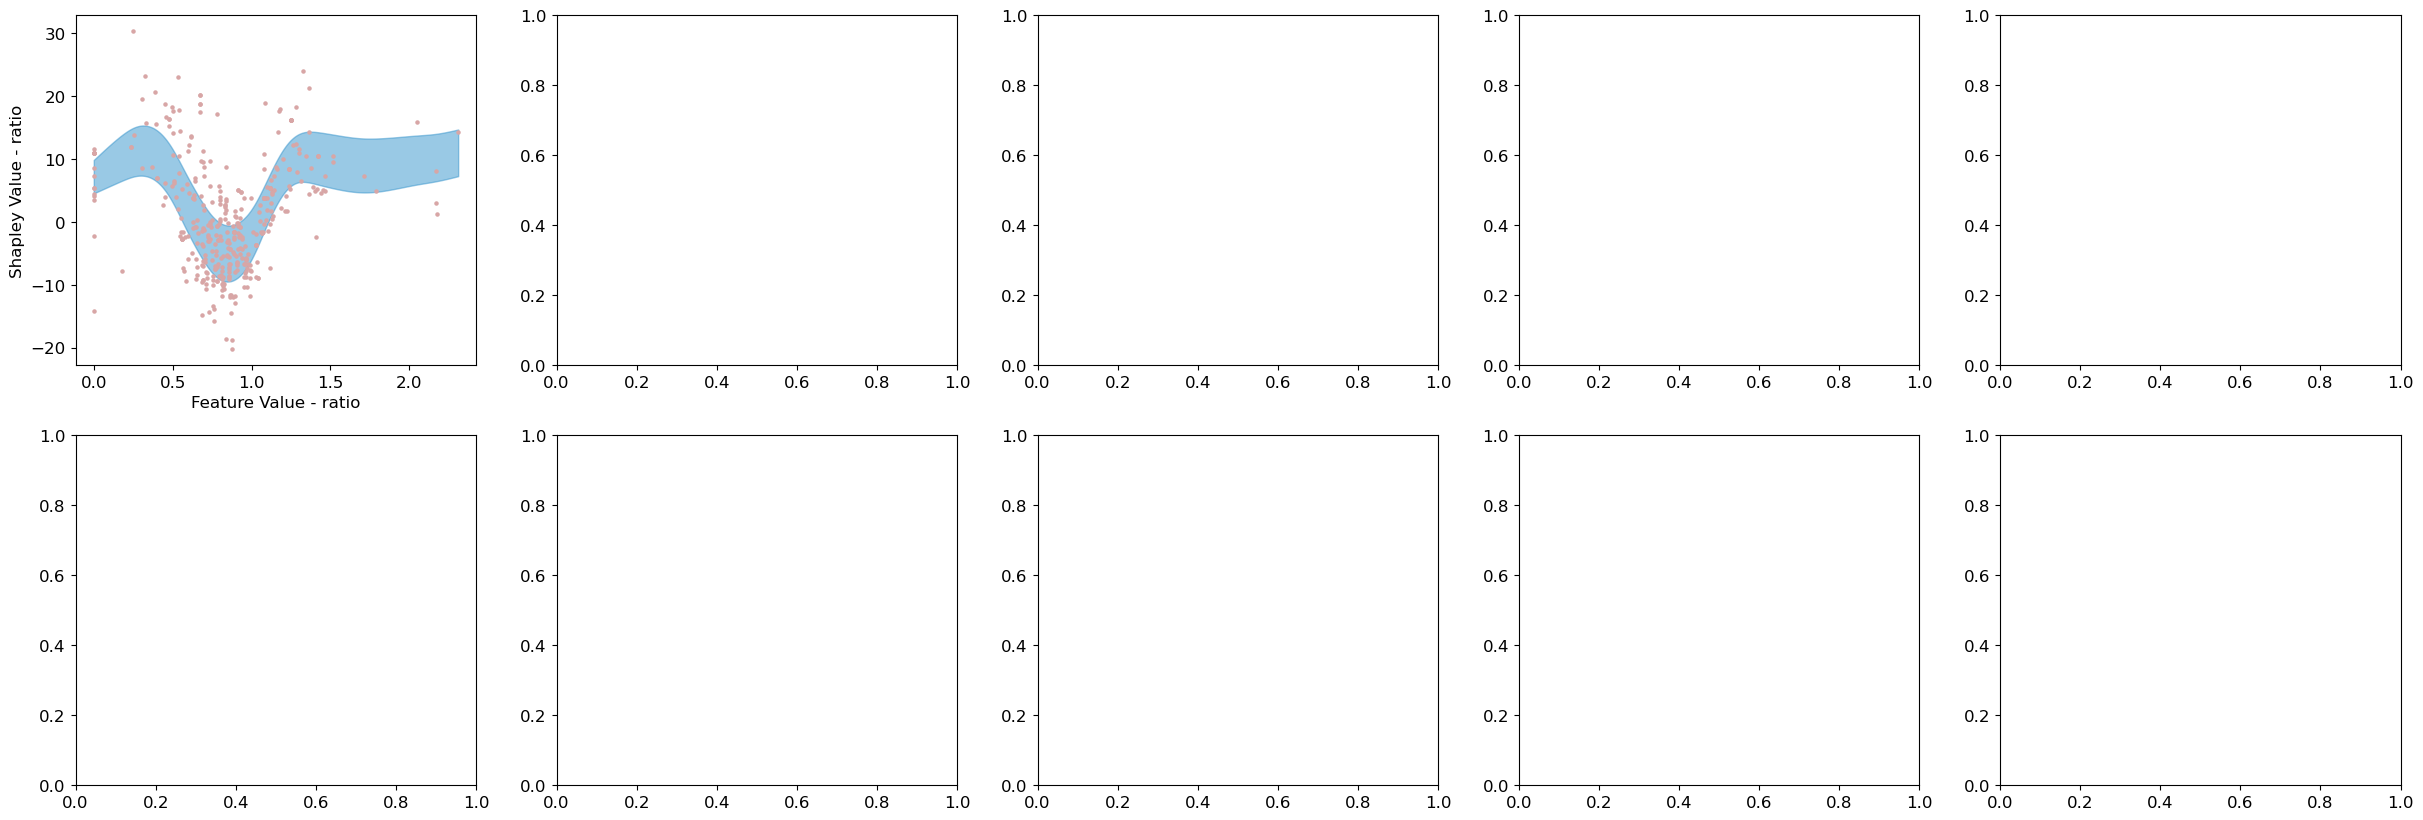

In [23]:
results.plot_partial_dependence_with_fitted_bounds(figsize=[30, 10])